# Trader Bot

## Objectives:
- Build a "trader" class
- Defining lookback window
- Defining breakout points
- Defining the trailing stop-loss
- Testing against sample data
- Refining the Algorithm: Momentum and Volume Analysis
- Connect to proper apis

## Trader Class (in progress)

This object monitors a given asset in real time, and decide when to open a position on it. It also automatically controls that position.

### Methods Needed:
* stop/start trading -- Turn it on or off
* analysis methods
* open/view/close position methods
* real time trading method

In [1]:
class Trader:
    # Specify the asset to monitor and how much cash to give the bot.
    def __init__(self, asset_symbol, cash):
        self.asset = asset_symbol 
        self.capital = cash
        self.active = False
        
    # prints all basic info for user
    def info(self):
        print("Asset:", self.asset,
             "\nCapital Allocated: $" + str(self.capital),
             "\nStatus:", "Active" if self.active else "Not Active")
        
    # Turns the bot on and off.
    def start_bot(self):
        self.active = True
    def stop_bot(self):
        self.active = False
        
    # opens/closes a new position
    def open_position(self):
        pass
    def close_position(self):
        pass
    def view_position(self):
        pass
    
    # analysis methods
    def analyze(self):
        pass
    # write aux analysis methods here
    
    # real time trading method
    def trade(self):
        pass

In [2]:
test_trader = Trader("GME", 25000)

In [3]:
test_trader.info()

Asset: GME 
Capital Allocated: $25000 
Status: Not Active


## Dynamic lookback window
<p>We first set an arbitrary lookback window. The unit here could be days, hours, or even seconds. <\p>
<p>At each market open, the algorithm adjusts this according to relative changes in volatility. Higher volatility should cause us to widen the window. The lookback window must stay within some reasonable range. For now, I define volatility as the 14-day average true range.<\p>

In [4]:
from finta import TA
import yfinance as yf # for easy test data

In [107]:
# test data
msft = yf.Ticker("MSFT")
hist = msft.history(period="30d")
hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-01-05,217.26,218.52,215.70,217.90,23823000,0,0
2021-01-06,212.17,216.49,211.94,212.25,35930700,0,0
2021-01-07,214.04,219.34,213.71,218.29,27694500,0,0
2021-01-08,218.68,220.58,217.03,219.62,22956200,0,0
2021-01-11,218.47,218.91,216.73,217.49,23047000,0,0
2021-01-12,216.50,217.10,213.32,214.93,23249300,0,0
2021-01-13,214.02,216.76,213.93,216.34,20087100,0,0
2021-01-14,215.91,217.46,212.74,213.02,29480800,0,0
2021-01-15,213.52,214.51,212.03,212.65,31746500,0,0


In [108]:
lookback = 20
ceiling, floor = 30, 10
atr = TA.ATR(hist)

In [109]:
today_atr, yesterday_atr = atr[-1], atr[-2]
today_atr, yesterday_atr

(4.743571428571433, 5.242857142857147)

In [110]:
delta_vol = (today_atr - yesterday_atr) / yesterday_atr
delta_vol

-0.09523160762942777

In [111]:
lookback = round(lookback * (1 + delta_vol))
lookback

18

## Define Breakouts

A breakout is defined as a closing price higher than the max price within the breakout window.

In [372]:
window = hist[-lookback:]["High"]
window

Date
2021-01-19    216.98
2021-01-20    225.79
2021-01-21    226.30
2021-01-22    230.07
2021-01-25    229.78
2021-01-26    234.18
2021-01-27    240.44
2021-01-28    242.64
2021-01-29    238.02
2021-02-01    242.50
2021-02-02    242.31
2021-02-03    245.09
2021-02-04    243.24
2021-02-05    243.28
2021-02-08    243.68
2021-02-09    244.76
2021-02-10    245.92
2021-02-11    245.15
2021-02-12    245.30
2021-02-16    246.13
Name: High, dtype: float64

In [116]:
hist["Close"][-1], max(window[:-1])

(243.7, 245.92)

Here, no breakout is detected.

## Defining our trailing stop-loss
We start with a stop-loss in mind. Let's put that at 2%. If the market continues to rise above our breakout point after we open the position, our stop-loss order should be higher too. We can define a trailing stop-loss, say 5%. If this is more than the original stop-loss, we update accordingly.

In [120]:
initial_stop, trail_stop = 0.98, 0.95
breakout_lvl, new_close =  200, 220 # example
stop_loss = breakout_lvl * initial_stop

if (new_close > breakout_lvl) and (new_close * trail_stop > initial_stop * breakout_lvl):
    stop_loss = new_close * trail_stop
    
stop_loss

209.0

## Testing
Let's create a sample price generator for testing. It generates Monte-Carlo paths using the Heston option-pricing model. A second function can apply the generator to create price histories in ohlc format.

In [77]:
import numpy as np

def stock_simulator(opening_price, ticks):
    
    N = ticks
    V_t = np.random.uniform(0.3) # initial variance
    S_t = opening_price
    kappa = 2 # mean reversion speed
    theta = np.random.uniform(0.3) # long run variance
    epsilon = np.random.uniform(0.2) # volatility of volatility
    rho = 0 # correlation
    prices = []
    
    for i in range(1, N):
        Z_s = np.random.normal()
        Z_v = rho * Z_s + np.sqrt(1 - rho**2) * np.random.normal()
        
        # Euler integration
        V_t = np.maximum(V_t, 0)
        S_t = S_t * np.exp( np.sqrt(V_t / N) * Z_s - V_t / 2 / N)                     #  Price process
        V_t = V_t + kappa * (theta - V_t) / N + epsilon * np.sqrt(V_t / N) * Z_v      # Volatility process
        
        prices.append(S_t)
    return prices

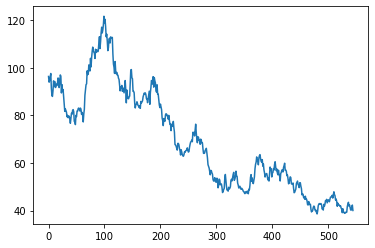

In [79]:
import pandas as pd
pd.Series(stock_simulator(100, 78*7)).plot()

In [80]:
def sample_history(opening_price, days):
    opening = opening_price
    ohlc = []
    history = stock_simulator(opening_price, 78 * days)
    for i in range(1, days):
        day = history[(i-1) * 78 : i * 78]
        ohlc.append([day[0], max(day), min(day), day[-1]])       
    return pd.DataFrame(data=ohlc, columns=["Open", "High", "Low", "Close"])

In [81]:
sample_history(100, 30)

,Open,High,Low,Close
0,98.354529,100.229618,83.002270,89.148932
1,89.169639,95.727834,84.097605,94.175765
2,94.661986,96.627227,81.132524,86.480284
3,87.532763,94.817852,80.780219,82.491576
4,81.831268,82.516225,50.530530,52.700522
5,54.149864,54.149864,41.090655,41.544385
6,40.994261,42.046130,35.673164,38.530595
7,38.172360,46.955438,36.445542,40.191697
8,40.059245,45.918750,37.959189,44.515821
9,45.118018,47.473586,37.242108,37.479825


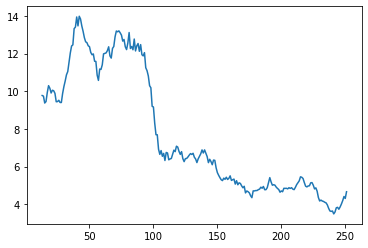

In [82]:
hist = sample_history(100, 253)
atr = TA.ATR(hist)
atr.plot()

## Testing the Breakout Algorithm

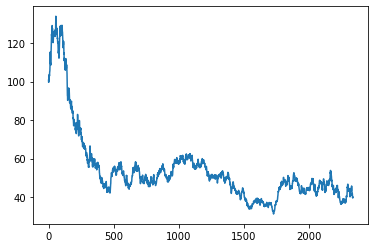

In [83]:
# We generate a month's worth of test data.

test_data = stock_simulator(100, 78*30)
pd.Series(test_data).plot()

In [105]:

# convert to ohlc -- but use 20-tick periods!
# repeat 1000 times, record profits
# month + 10 days of data
profits = []
stop_loss = 0.98
trail_loss = 0.8
for monte in range(1000):
    test_data = stock_simulator(10, 78*40)
    ohlc = []
    for i in range(1, 157):
        day = test_data[(i-1) * 20 : i * 20]
        ohlc.append([day[0], max(day), min(day), day[-1]])
    hist = pd.DataFrame(data=ohlc, columns=["Open", "High", "Low", "Close"])
    atr = TA.ATR(hist)
    macd = TA.MACD(hist)

    # identify breakouts, macd buy/sell signals starting after day 10
    lookback = 15
    ceiling, floor = 25, 5
    buy, sell = [], []
    bought = False

    for i in range(39, 156):
        if ((bought == False) and 
            (((hist["Close"][i]) > (max(hist["High"][i-lookback:i]))) and (macd['MACD'][i] > macd['SIGNAL'][i]))):
            buy.append(test_data[i*20])
            bought = True
            stop_price = test_data[i*20]
        elif bought: # check stop loss
            for ticks in test_data[(i-1)*20:i*20]:
                if ticks <= stop_price:
                    sell.append(stop_price)
                    bought = False
                    break
        if (len(buy)>0 and bought and hist["Close"][i]) > (max(hist["High"][i-lookback:i])): # trailing stop-loss
            if (test_data[i*20] > buy[-1]) and (test_data[i*20] * trail_loss > stop_price):
                stop_price = test_data[i*20] * trail_loss
            
        if bought and (macd['MACD'][i] < macd['SIGNAL'][i]): # sell signal
            sell.append(test_data[i*20])
            bought = False
            
        # adjust lookback window
        lookback = round(lookback * (1 + (atr[i]-atr[i-1])/atr[i-1]))
        if lookback > ceiling:
            lookback = ceiling
        elif lookback < floor:
            lookback = floor
    
    if len(sell) < len(buy): # sells at the end if position still open
        sell.append(test_data[-1])
        
    capital = 25000
    for i in range(len(buy)):
        stock = capital/buy[i]
        capital = stock * sell[i]
        
    
    profits.append(capital - 25000)
    
print(np.average(profits)/250, np.min(profits)/250, np.max(profits)/250)

0.569192023667152 -0.8581303235645173 23.601688283505222


In [38]:
# identify breakouts, macd buy/sell signals starting after day 10
from finta import TA
lookback = 15
ceiling, floor = 25, 5
buy, sell = [], []
bought = False

for i in range(39, 117):
    if ((bought == False) and 
        (((hist["Close"][i]) > (max(hist["High"][i-lookback:i]))) or (macd['MACD'][i] > macd['SIGNAL'][i]))):
        buy.append(i*20)
        bought = True
    elif (bought == True) and (macd['MACD'][i] < macd['SIGNAL'][i]):
        sell.append(i*20)
        bought = False
    # adjust lookback
    lookback = round(lookback * (1 + (atr[i]-atr[i-1])/atr[i-1]))
    if lookback > ceiling:
        lookback = ceiling
    elif lookback < floor:
        lookback = floor

In [696]:
buy, sell

([1120, 1460, 2000, 2580, 3020], [1300, 1760, 2460, 2600, 3118])

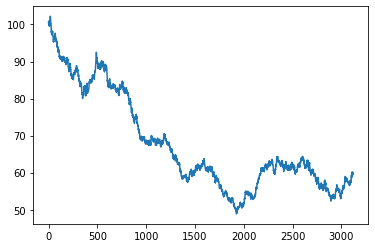

In [697]:
pd.Series(test_data).plot()

In [698]:
capital = 25000
for i in range(len(sell)):
    stock = capital/test_data[buy[i]]
    capital = stock * test_data[sell[i]]
    
print((capital - 25000)/25000*100/len(buy), "% return per cycle")

3.1693890248600622 % return per cycle


In [701]:
np.max(profits)/250, np.min(profits)/250

(144.65178097578774, -20.7719518465571)

In [89]:
buy[-1]

IndexError: list index out of range